# Hierarchical linear regression for the radon dataset

Based on https://twiecki.io/blog/2014/03/17/bayesian-glms-3/
and https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

This code uses [blackjax](https://github.com/blackjax-devs/blackjax) for MCMC inference. See also these alternative (deprecated) implementations.
- [pymc3, centered](https://github.com/probml/pyprobml/blob/master/notebooks/book2/15/linreg_hierarchical_pymc3.ipynb)
- [pymc3, noncentered](https://github.com/probml/pyprobml/blob/master/notebooks/book2/15/linreg_hierarchical_non_centered_pymc3.ipynb)
- [numpyro, centered](https://github.com/probml/pyprobml/blob/master/notebooks/book2/15/linreg_hierarchical_numpyro.ipynb)
- [numpyro, noncentered](https://github.com/probml/pyprobml/blob/master/notebooks/book2/15/linreg_hierarchical_non_centered_numpyro.ipynb)



Gelman et al.'s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all county's of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to enter the house through the basement. Moreover, its concentration is thought to differ regionally due to different types of soil.

Here we'll investigate this difference and try to make predictions of radon levels in different countys and where in the house radon was measured. In this example we'll look at Minnesota, a state that contains 85 county's in which different measurements are taken, ranging from 2 till 80 measurements per county.

In [ ]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax.random import PRNGKey, split

try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax
try:
    from tensorflow_probability.substrates.jax.distributions import HalfCauchy
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    from tensorflow_probability.substrates.jax.distributions import HalfCauchy

try:
    import blackjax.nuts as nuts
except ModuleNotFoundError:
    %pip install -qq blackjax
    import blackjax.nuts as nuts

import blackjax.stan_warmup as stan_warmup

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az
from functools import partial

sns.set_style("whitegrid")
np.random.seed(123)

In [ ]:
url = "https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/radon.csv?raw=true"
data = pd.read_csv(url)

In [ ]:
county_names = data.county.unique()
county_idx = jnp.array(data.county_code.values)
n_counties = len(county_names)
X = data.floor.values
Y = data.log_radon.values

In [ ]:
def init_non_centered_params(n_counties, rng_key=None):
    params = {}

    if rng_key is None:
        rng_key = PRNGKey(0)

    mu_a_key, mu_b_key, sigma_a_key, sigma_b_key, a_key, b_key, eps_key = split(rng_key, 7)
    half_cauchy = distrax.as_distribution(HalfCauchy(loc=0.0, scale=5.0))

    params["mu_a"] = distrax.Normal(0.0, 1.0).sample(seed=mu_a_key)
    params["mu_b"] = distrax.Normal(0.0, 1.0).sample(seed=mu_b_key)

    params["sigma_a"] = half_cauchy.sample(seed=sigma_a_key)
    params["sigma_b"] = half_cauchy.sample(seed=sigma_b_key)

    params["a_offsets"] = distrax.Normal(0.0, 1.0).sample(seed=a_key, sample_shape=(n_counties,))
    params["b_offsets"] = distrax.Normal(0.0, 1.0).sample(seed=b_key, sample_shape=(n_counties,))

    params["eps"] = half_cauchy.sample(seed=eps_key)

    return params

In [ ]:
def init_centered_params(n_counties, rng_key=None):
    params = {}

    if rng_key is None:
        rng_key = PRNGKey(0)

    mu_a_key, mu_b_key, sigma_a_key, sigma_b_key, a_key, b_key, eps_key = split(rng_key, 7)
    half_cauchy = distrax.as_distribution(HalfCauchy(loc=0.0, scale=5.0))

    params["mu_a"] = distrax.Normal(0.0, 1.0).sample(seed=mu_a_key)
    params["mu_b"] = distrax.Normal(0.0, 1.0).sample(seed=mu_b_key)

    params["sigma_a"] = half_cauchy.sample(seed=sigma_a_key)
    params["sigma_b"] = half_cauchy.sample(seed=sigma_b_key)

    params["b"] = distrax.Normal(params["mu_b"], params["sigma_b"]).sample(seed=b_key, sample_shape=(n_counties,))
    params["a"] = distrax.Normal(params["mu_a"], params["sigma_a"]).sample(seed=a_key, sample_shape=(n_counties,))

    params["eps"] = half_cauchy.sample(seed=eps_key)

    return params

In [ ]:
def log_joint_non_centered(params, X, Y, county_idx, n_counties):
    log_theta = 0

    log_theta += distrax.Normal(0.0, 100**2).log_prob(params["mu_a"]) * n_counties
    log_theta += distrax.Normal(0.0, 100**2).log_prob(params["mu_b"]) * n_counties

    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["sigma_a"]) * n_counties
    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["sigma_b"]) * n_counties

    log_theta += distrax.Normal(0.0, 1.0).log_prob(params["a_offsets"]).sum()
    log_theta += distrax.Normal(0.0, 1.0).log_prob(params["b_offsets"]).sum()

    log_theta += jnp.sum(distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["eps"]))

    # Linear regression
    a = params["mu_a"] + params["a_offsets"] * params["sigma_a"]
    b = params["mu_b"] + params["b_offsets"] * params["sigma_b"]
    radon_est = a[county_idx] + b[county_idx] * X

    log_theta += jnp.sum(distrax.Normal(radon_est, params["eps"]).log_prob(Y))

    return -log_theta

In [ ]:
def log_joint_centered(params, X, Y, county_idx):
    log_theta = 0

    log_theta += distrax.Normal(0.0, 100**2).log_prob(params["mu_a"]).sum()
    log_theta += distrax.Normal(0.0, 100**2).log_prob(params["mu_b"]).sum()

    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["sigma_a"]).sum()
    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["sigma_b"]).sum()

    log_theta += distrax.Normal(params["mu_a"], params["sigma_a"]).log_prob(params["a"]).sum()
    log_theta += distrax.Normal(params["mu_b"], params["sigma_b"]).log_prob(params["b"]).sum()

    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["eps"]).sum()

    # Linear regression
    radon_est = params["a"][county_idx] + params["b"][county_idx] * X
    log_theta += distrax.Normal(radon_est, params["eps"]).log_prob(Y).sum()
    return -log_theta

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [ ]:
def fit_hierarchical_model(
    X, Y, county_idx, n_counties, is_centered=True, num_warmup=1000, num_samples=5000, rng_key=None
):
    if rng_key is None:
        rng_key = PRNGKey(0)

    init_key, warmup_key, sample_key = split(rng_key, 3)

    if is_centered:
        potential = partial(log_joint_centered, X=X, Y=Y, county_idx=county_idx)
        params = init_centered_params(n_counties, rng_key=init_key)
    else:
        potential = partial(log_joint_non_centered, X=X, Y=Y, county_idx=county_idx, n_counties=n_counties)
        params = init_non_centered_params(n_counties, rng_key=init_key)

    initial_state = nuts.new_state(params, potential)

    kernel_factory = lambda step_size, inverse_mass_matrix: nuts.kernel(potential, step_size, inverse_mass_matrix)

    last_state, (step_size, inverse_mass_matrix), _ = stan_warmup.run(
        warmup_key, kernel_factory, initial_state, num_warmup
    )

    kernel = kernel_factory(step_size, inverse_mass_matrix)

    states = inference_loop(sample_key, kernel, initial_state, num_samples)
    return states

In [ ]:
states_centered = fit_hierarchical_model(X, Y, county_idx, n_counties, is_centered=True)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: Use

In [ ]:
states_non_centered = fit_hierarchical_model(X, Y, county_idx, n_counties, is_centered=False)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: Use

## Centered Hierarchical Model

In [ ]:
def plot_funnel_of_hell(x, sigma_x, k=75):
    x = pd.Series(x[:, k].flatten(), name=f"slope b_{k}")
    y = pd.Series(sigma_x.flatten(), name="slope group variance sigma_b")

    sns.jointplot(x=x, y=y, ylim=(0.0, 0.7), xlim=(-2.5, 1.0));

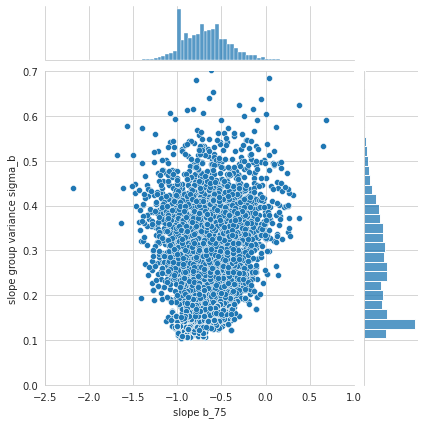

In [ ]:
samples_centered = states_centered.position
b_centered = samples_centered["b"]
sigma_b_centered = samples_centered["sigma_b"]
plot_funnel_of_hell(b_centered, sigma_b_centered)

In [ ]:
def plot_single_chain(x, sigma_x, name):
    fig, axs = plt.subplots(nrows=2, figsize=(16, 6))
    axs[0].plot(sigma_x, alpha=0.5)
    axs[0].set(ylabel=f"sigma_{name}")
    axs[1].plot(x, alpha=0.5)
    axs[1].set(ylabel=name);

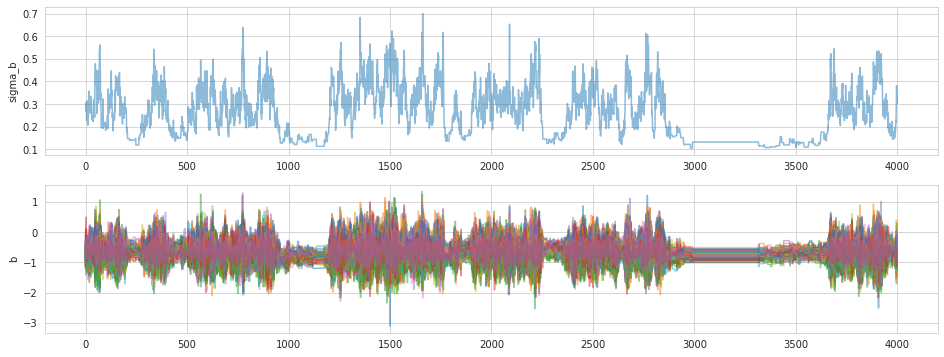

In [ ]:
plot_single_chain(b_centered[1000:], sigma_b_centered[1000:], "b")

## Non-Centered Hierarchical Model

In [ ]:
samples_non_centered = states_non_centered.position
b_non_centered = (
    samples_non_centered["mu_b"][..., None]
    + samples_non_centered["b_offsets"] * samples_non_centered["sigma_b"][..., None]
)
sigma_b_non_centered = samples_non_centered["sigma_b"]

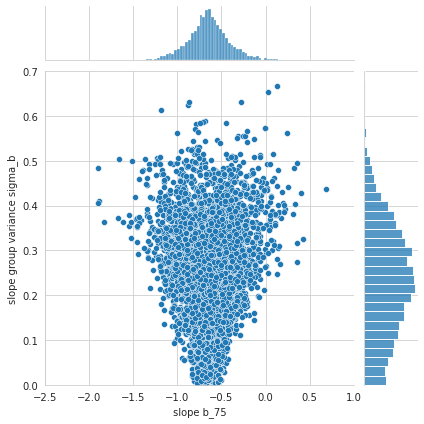

In [ ]:
plot_funnel_of_hell(b_non_centered, sigma_b_non_centered)

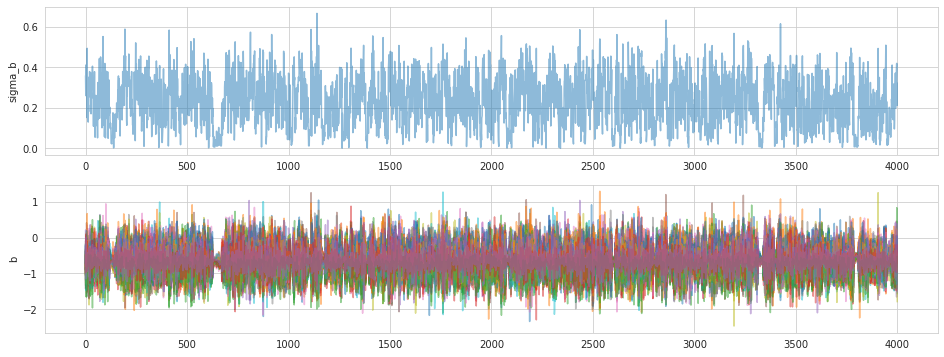

In [ ]:
plot_single_chain(b_non_centered[1000:], sigma_b_non_centered[1000:], "b")

## Comparison

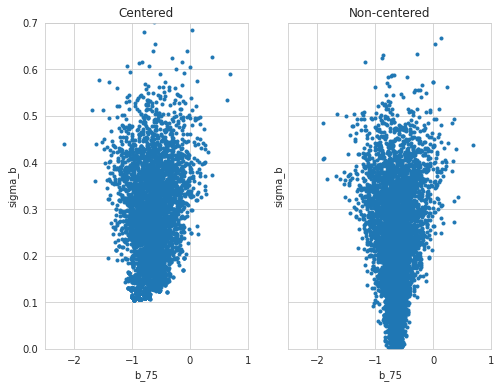

In [ ]:
k = 75
x_lim, y_lim = [-2.5, 1], [0, 0.7]

bs = [(b_centered, sigma_b_centered, "Centered"), (b_non_centered, sigma_b_non_centered, "Non-centered")]
ncols = len(bs)

fig, axs = plt.subplots(ncols=ncols, sharex=True, sharey=True, figsize=(8, 6))

for i, (b, sigma_b, model_name) in enumerate(bs):
    x = pd.Series(b[:, k], name=f"slope b_{k}")
    y = pd.Series(sigma_b, name="slope group variance sigma_b")
    axs[i].plot(x, y, ".")
    axs[i].set(title=model_name, ylabel="sigma_b", xlabel=f"b_{k}")
    axs[i].set_xlim(x_lim)
    axs[i].set_ylim(y_lim)